In [1]:
import numpy as np
import pandas as pd
import math 
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv' ) # Train
test = pd.read_csv('test.csv' ) # Test
test_df = test.copy()

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Features:
    PassengerId : The id given to each traveller on the boat.
    Pclass : The Passenger class. It has three possible values: 1,2,3 (first, second and third class).
    Name : The Name of the passeger.
    Sex : The Gender of the Passenger.
    Age : The Age of the Passenger.
    SibSp : The number of siblings and spouses traveling with the passenger.
    Parch : number of parents and children traveling with the passenger.
    Ticket : The ticket number of the Passenger.
    Fare : The ticket Fare of the passenger
    Cabin : The cabin number.
    Embarked : This describe three areas of the Titanic from which the people embark. Three possible values S,C,Q (Southampton, Cherbourg, Queenstown).
    Qualitative Features (Categorical) : PassengerId , Pclass , Survived , Sex , Ticket , Cabin , Embarked.

    Quantitative Features (Numerical) : SibSp , Parch , Age , Fare.

    Survival is the Target Variable.


In [4]:
train.shape

(891, 12)

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have null values in Age and Cabin.

In [6]:
# Look at the percentage
train.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

#### So, out of 891 examples only 342 (38%) survived and rest all died.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


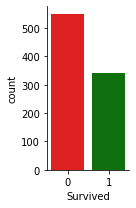

In [7]:
sns.factorplot(x='Survived' , kind='count' , data=train , palette=['r','g'] , size=3 , aspect=.6)

Let's examine the survival ratio based on Pclass to see if some people were given the priority.

In [8]:
pd.crosstab(train.Pclass , train.Survived , margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [9]:
train[['Pclass' , 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


#### The trend of decreasing survival rate can be clearly seen on the basis of Pclass. Therefore, we see that high class were given more priority.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


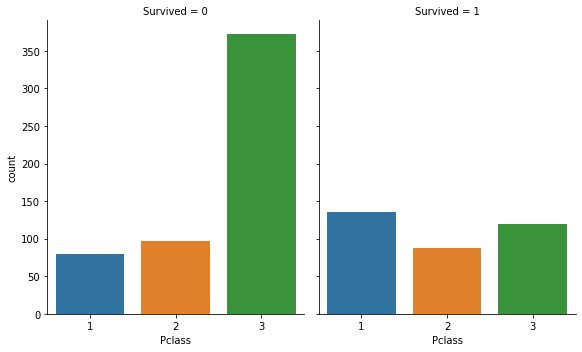

In [10]:
sns.factorplot(x='Pclass' , data=train , col='Survived' , kind='count' , size=5 , aspect=.8)

#### Let's see if there was a preference based on gender in saving lives

In [11]:
pd.crosstab(train.Sex , train.Survived , margins=True,normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


#### We can see that clearly ratio of survival of female to men is almost 3:1.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


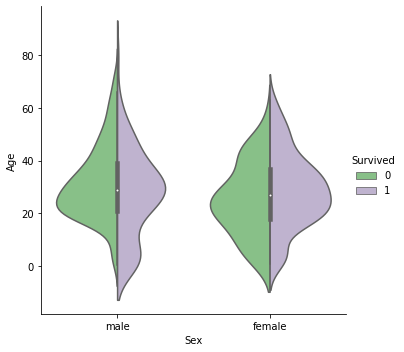

In [12]:
sns.factorplot(x='Sex' , y='Age' , data=train , hue='Survived' , kind='violin' , palette='Accent' , split=True)

We can see that Males have Surviving Density less than Females (Bulged) . And majority of those who survived belonged to the category of Age limit 20-30 . Same is true for the Death Scenario.

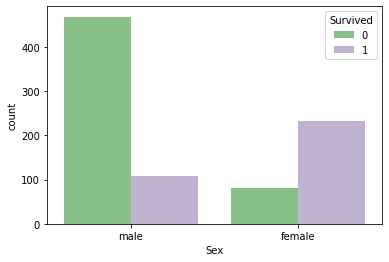

In [13]:
sns.countplot(x='Sex',data=train,hue='Survived',palette='Accent')

#### The above graph is a clear indication of above results.

#### Now for examining age, we need to first impute it...

In [14]:
train['Age']=train['Age'].fillna(train['Age'].median())

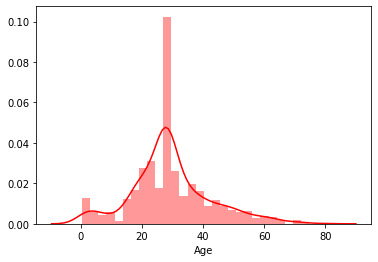

In [15]:
sns.distplot(train.Age , color='r')

#### I used median to fill empty points because of the outliers present in it. We can also infer that most of the people were close to age 30.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


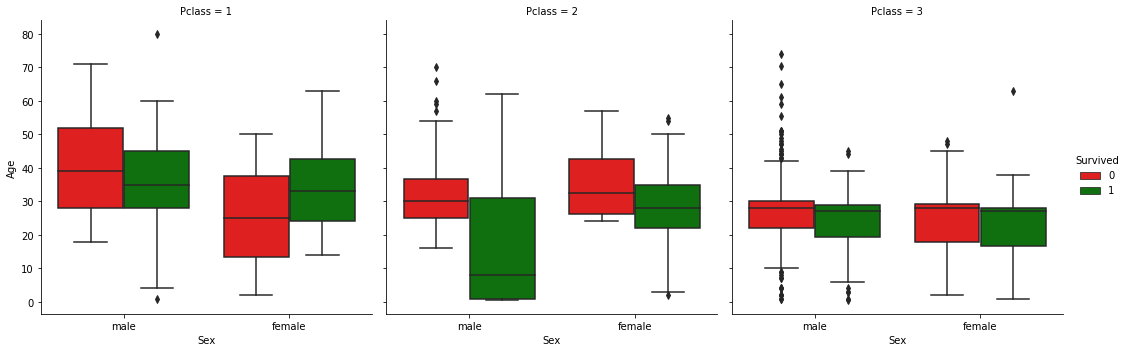

In [16]:
sns.factorplot(x='Sex',y='Age' , col='Pclass', data=train , hue='Survived' , kind = 'box', palette=['r','g'])

We can see that net survival is more in Pclass 1 as discussed earlier and minimum in Pclass3.

#### Some more insights:
    Many men (younger in age) in Pclass2 survived and the number was even more than the women.
    It seems that the passengers of class3 belong to a particular age group only.
    But there do exist some extreme outliers.

### Let's see if fare has some impact..

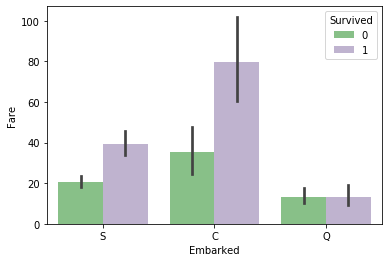

In [17]:
sns.barplot(train['Embarked'] , y =train['Fare'] ,hue=train['Survived'],palette='Accent')

#### We can see that those who paid high were likely to Survive.

##### To study embarked we need to first impute it..

In [18]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

In [19]:
pd.crosstab([train.Sex,train.Survived] , [train.Pclass,train.Embarked] , margins=True)

Pclass            1           2           3           All
Embarked          C  Q    S   C  Q    S   C   Q    S     
Sex    Survived                                          
female 0          1  0    2   0  0    6   8   9   55   81
       1         42  1   48   7  2   61  15  24   33  233
male   0         25  1   51   8  1   82  33  36  231  468
       1         17  0   28   2  0   15  10   3   34  109
All              85  2  129  17  3  164  66  72  353  891

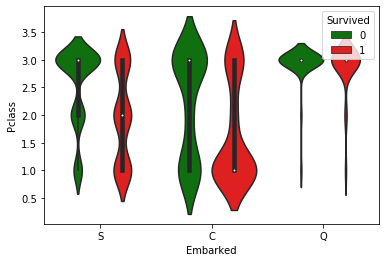

In [20]:
sns.violinplot(x='Embarked' , y='Pclass' , data=train , hue='Survived' , palette=['g','r'])

#### We can see that those who embarked at C with First Class ticket had a good chance of Survival. Whereas for S, it seems that all classes had nearly equal probability of Survival. And for Q, third Class seems to have Survived and Died with similar probabilities.

### Let's examine on the basis of Siblings..

In [21]:
train[['SibSp' , 'Survived']].groupby('SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


#### It seems that there individuals having 1 or 2 siblings/spouses had the highest Probability of Survival, followed by individuals who were Alone.

### Now let's examine Parch

In [22]:
train[['Parch','Survived']].groupby('Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


#### It seems that individuals with 1,2 or 3 family members had a greater Probability of Survival, followed by individuals who were Alone.

Looking at Parch and SibSp, we can see that individuals having Family Members had a slightly greater chance of Survival.


## Feature Engineering

In [23]:
labels_train = train['Survived']
train.drop('Survived', axis=1, inplace=True)

In [24]:
combined_features = train.append(test)
combined_features.reset_index(inplace=True)
combined_features.drop('index', axis=1, inplace=True)

In [25]:
combined_features['Title']= combined_features['Name'].map(
    lambda name: name.split(',')[1].split('.')[0].strip())
Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
combined_features['Title']=combined_features.Title.map(Title_Dictionary)

In [26]:
grouped_train = combined_features.head(891).groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()

In [27]:
grouped_test = combined_features.iloc[891:].groupby(['Sex','Pclass','Title'])
grouped_median_test = grouped_test.median()
def fillAges(row, grouped_median):
    if row['Sex'] == 'female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 1, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 1, 'Mrs']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['female', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['female', 1, 'Royalty']['Age']

    elif row['Sex'] == 'female' and row['Pclass'] == 2:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 2, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 2, 'Mrs']['Age']

    elif row['Sex'] == 'female' and row['Pclass'] == 3:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 3, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 3, 'Mrs']['Age']

    elif row['Sex'] == 'male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 1, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 1, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['male', 1, 'Royalty']['Age']

    elif row['Sex'] == 'male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 2, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 2, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 2, 'Officer']['Age']

    elif row['Sex'] == 'male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 3, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 3, 'Mr']['Age']

combined_features.head(891).Age = combined_features.head(891).apply(lambda r: fillAges(r, grouped_median_train) if np.isnan(r['Age'])
    else r['Age'], axis=1)

combined_features.iloc[891:].Age = combined_features.iloc[891:].apply(lambda r: fillAges(r, grouped_median_test) if np.isnan(r['Age'])
    else r['Age'], axis=1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [28]:
# Processing names: drop names and encode the titles using dummy encoding from pandas
combined_features.drop('Name', axis=1, inplace=True)
dummy_titles = pd.get_dummies(combined_features['Title'], prefix='Title')
combined_features = pd.concat([combined_features, dummy_titles], axis=1)
combined_features.drop('Title', axis=1, inplace=True)

In [29]:
# Processing Fares: fill empty spaces with mean
combined_features.head(891).Fare.fillna(combined_features.head(891).Fare.mean(), inplace=True)
combined_features.iloc[891:].Fare.fillna(combined_features.iloc[891:].Fare.mean(), inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [30]:
#Processing Embarked: drop it
combined_features.drop('Embarked', axis=1, inplace=True)

#Processing Ticket: drop it
combined_features.drop('Ticket', axis=1, inplace=True)

In [31]:
#Processing Cabin:
combined_features.Cabin.fillna('U', inplace=True)

# mapping each Cabin value with the cabin letter
combined_features['Cabin'] = combined_features['Cabin'].map(lambda c: c[0])

cabin_dummies = pd.get_dummies(combined_features['Cabin'], prefix='Cabin')
combined_features = pd.concat([combined_features, cabin_dummies], axis=1)
combined_features.drop('Cabin', axis=1, inplace=True)

In [32]:
# Processing sex
combined_features['Sex'] = combined_features['Sex'].map({'male':1,'female':0})

In [33]:
# Processing pclass
pclass_dummies = pd.get_dummies(combined_features['Pclass'], prefix="Pclass")
combined_features = pd.concat([combined_features, pclass_dummies], axis=1)
combined_features.drop('Pclass', axis=1, inplace=True)

In [34]:
# Processing PassengerId
combined_features.drop('PassengerId', axis=1, inplace=True)

In [35]:
# Processing family
combined_features['FamilySize'] = combined_features['Parch'] + combined_features['SibSp'] + 1
combined_features['Singleton'] = combined_features['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined_features['SmallFamily'] = combined_features['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined_features['LargeFamily'] = combined_features['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
combined_features.drop('Parch', axis=1, inplace=True)
combined_features.drop('SibSp', axis=1, inplace=True)

In [36]:
#Scaling
scale=max(combined_features['Age'])
combined_features['Age']/=scale
mean=np.mean(combined_features['Age'])
combined_features['Age']-=mean

scale=max(combined_features['Fare'])
combined_features['Fare']/=scale
mean=np.mean(combined_features['Fare'])
combined_features['Fare']-=mean


print(combined_features.head())

   Sex       Age      Fare  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0    1 -0.092195 -0.050841             0           0         1          0   
1    0  0.107805  0.074144             0           0         0          1   
2    0 -0.042195 -0.049523             0           1         0          0   
3    0  0.070305  0.038652             0           0         0          1   
4    1  0.070305 -0.049279             0           0         1          0   

   Title_Officer  Title_Royalty  Cabin_A  ...  Cabin_G  Cabin_T  Cabin_U  \
0              0              0        0  ...        0        0        1   
1              0              0        0  ...        0        0        0   
2              0              0        0  ...        0        0        1   
3              0              0        0  ...        0        0        0   
4              0              0        0  ...        0        0        1   

   Pclass_1  Pclass_2  Pclass_3  FamilySize  Singleton  SmallFamily  \
0        

In [37]:
features_train=combined_features[:891]
features_test=combined_features[891:]

In [44]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import categorical_accuracy as accuracy
from keras import regularizers
from sklearn.model_selection import cross_val_score
model = Sequential()
model.add(Dense(512, input_dim=25))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
labels_train = np_utils.to_categorical(labels_train)

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
clf=model

W0830 00:49:53.752465 4638721472 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 00:49:53.756165 4638721472 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 00:49:53.786765 4638721472 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0830 00:49:53.808260 4638721472 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backen

In [45]:
clf.fit(np.array(features_train),labels_train,validation_split=0.1,epochs=88)
out = clf.predict(np.array(features_test))
#print(accuracy_score(out,labels_test))
pred=[]
for x in out:
    if(x[1]>0.5):
        pred.append(1)
    else:
        pred.append(0)

out1=pred

W0830 00:50:15.171813 4638721472 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 801 samples, validate on 90 samples
Epoch 1/88
801/801 [==============================] - 1s 956us/step - loss: 0.5599 - acc: 0.7166 - val_loss: 0.4291 - val_acc: 0.8111
Epoch 2/88
801/801 [==============================] - 0s 258us/step - loss: 0.4649 - acc: 0.8102 - val_loss: 0.3904 - val_acc: 0.8222
Epoch 3/88
801/801 [==============================] - 0s 162us/step - loss: 0.4330 - acc: 0.8190 - val_loss: 0.3611 - val_acc: 0.8444
Epoch 4/88
801/801 [==============================] - 0s 122us/step - loss: 0.4232 - acc: 0.8315 - val_loss: 0.3467 - val_acc: 0.8444
Epoch 5/88
801/801 [==============================] - 0s 125us/step - loss: 0.4206 - acc: 0.8265 - val_loss: 0.3690 - val_acc: 0.8556
Epoch 6/88
801/801 [==============================] - 0s 113us/step - loss: 0.4057 - acc: 0.8227 - val_loss: 0.3402 - val_acc: 0.8444
Epoch 7/88
801/801 [==============================] - 0s 113us/step - loss: 0.4334 - acc: 0.8115 - val_loss: 0.3344 - val_acc: 0.8556
Epoch 8/88
801/80

801/801 [==============================] - 0s 108us/step - loss: 0.3442 - acc: 0.8564 - val_loss: 0.3128 - val_acc: 0.8333
Epoch 62/88
801/801 [==============================] - 0s 150us/step - loss: 0.3461 - acc: 0.8577 - val_loss: 0.3272 - val_acc: 0.8556
Epoch 63/88
801/801 [==============================] - 0s 162us/step - loss: 0.3518 - acc: 0.8514 - val_loss: 0.3148 - val_acc: 0.8556
Epoch 64/88
801/801 [==============================] - 0s 108us/step - loss: 0.3416 - acc: 0.8539 - val_loss: 0.3186 - val_acc: 0.8556
Epoch 65/88
801/801 [==============================] - 0s 127us/step - loss: 0.3485 - acc: 0.8477 - val_loss: 0.3236 - val_acc: 0.8667
Epoch 66/88
801/801 [==============================] - 0s 107us/step - loss: 0.3483 - acc: 0.8527 - val_loss: 0.3224 - val_acc: 0.8556
Epoch 67/88
801/801 [==============================] - 0s 102us/step - loss: 0.3515 - acc: 0.8502 - val_loss: 0.3053 - val_acc: 0.8444
Epoch 68/88
801/801 [==============================] - 0s 98us/step

In [47]:
import csv
idk = open('test.csv','r')
idk = csv.DictReader(idk)
pred = []
for row in idk:
    pred.append(row["PassengerId"])
est = csv.writer(open('result.csv', 'w'), delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
est.writerows([["PassengerID","Survived"]])
k=0
for x in pred:
    est.writerows([[str(x), str(out1[k])]])
    k+=1